# Title : Predict the market value of car

##  Introduction

Rusty Bargain used car sales service is developing an app to attract new customers. In this app, we can quickly find out the market value of our car. We have access to historical data: technical specifications, trim versions, and prices. We need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

For this the project is divided into three steps.
- Data preparation
- Model training
- Model analysis

## Data preparation

In this stage load all the important libraries needed and load the data to variable df. Check the dtypes and convert to appropriate form. check the missing values, duplicates in the data etc and prepare the data for model training.

In [27]:
#Load the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor, Pool
import xgboost as xgb

In [2]:
#Load the data
df=pd.read_csv('/datasets/car_data.csv')
display(df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15


The data consists of 354369 rows and 16 columns. The columns are
- DateCrawled — date profile was downloaded from the database
- VehicleType — vehicle body type
- RegistrationYear — vehicle registration year
- Gearbox — gearbox type
- Power — power (hp)
- Model — vehicle model
- Mileage — mileage (measured in km due to dataset's regional specifics)
- RegistrationMonth — vehicle registration month
- FuelType — fuel type
- Brand — vehicle brand
- NotRepaired — vehicle repaired or not
- DateCreated — date of profile creation
- NumberOfPictures — number of vehicle pictures
- PostalCode — postal code of profile owner (user)
- LastSeen — date of the last activity of the user
- Price — price (Euro)

In [3]:
#Convert column names to snake case
df.columns = df.columns.str.replace('([a-z])([A-Z])', r'\1_\2').str.lower()

In [4]:
#Check for column names
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

In [5]:
#Check dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

From the above information dates are object type and convert it into datetime type.

In [6]:
#Convert to datetime type.
df['date_crawled'] = pd.to_datetime(df['date_crawled'])
df['date_created'] = pd.to_datetime(df['date_created'])
df['last_seen'] = pd.to_datetime(df['last_seen'])

In [7]:
#recheck
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   mileage             354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  not_repaired        283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

In [6]:
#Check for missing values
df.isnull().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
mileage                   0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [7]:
#Check for duplicates
df.duplicated().sum()

262

In [8]:
#Remove duplicates
df=df.drop_duplicates()

There are missing values in the columns vehicle type, gearbox, model, fuel type, and notrepaired. In the prediction some columns like date crawled, date created, number of pictures, postal code, lastseen etc are not useful. So we can drop them.

In [9]:
#Drop the columns that are not useful for prediction
df=df.drop(columns=['date_crawled','date_created','number_of_pictures','postal_code','last_seen'])

In [10]:
#Check the minimum, maximum values
df.describe()

,price,registration_year,power,mileage,registration_month
count,354107.000000,354107.000000,354107.000000,354107.000000,354107.000000
mean,4416.433287,2004.235355,110.089651,128211.811684,5.714182
std,4514.338584,90.261168,189.914972,37906.590101,3.726682
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


From the above table, we can find the maximum, minimum, mean etc of different columns. From the above the maximum registration year is 9999 may be an error. So remove the outliers in year, price, power etc. Maximum power is 20000 may be an error. A car with hp 20000 is not practically possible. So remove the ouliers and prepare the data for prediction.

In [11]:
# Handle unreasonable values
df = df[(df['price'] > 100) & (df['price'] < 100000)]
# Consider data for last 25 years
df = df[(df['registration_year'] >= 2000) & (df['registration_year'] <= 2025)]
df = df[(df['power'] >= 10) & (df['power'] < 10000)]

In [12]:
df

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
...,...,...,...,...,...,...,...,...,...,...,...
354359,7900,sedan,2010,manual,140,golf,150000,7,gasoline,volkswagen,no
354361,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no


In [12]:
#Check for missing values
df.isnull().sum()

price                     0
vehicle_type          19689
registration_year         0
gearbox                4237
power                     0
model                  7465
mileage                   0
registration_month        0
fuel_type             13714
brand                     0
not_repaired          29541
dtype: int64

In [13]:
# Fill missing values
df['vehicle_type'].fillna('missing', inplace=True)
df['gearbox'].fillna('missing', inplace=True)
df['model'].fillna('missing', inplace=True)
df['fuel_type'].fillna('missing', inplace=True)
df['not_repaired'].fillna('missing', inplace=True)

In [14]:
#Recheck for missing values
df.isnull().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
mileage               0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
dtype: int64

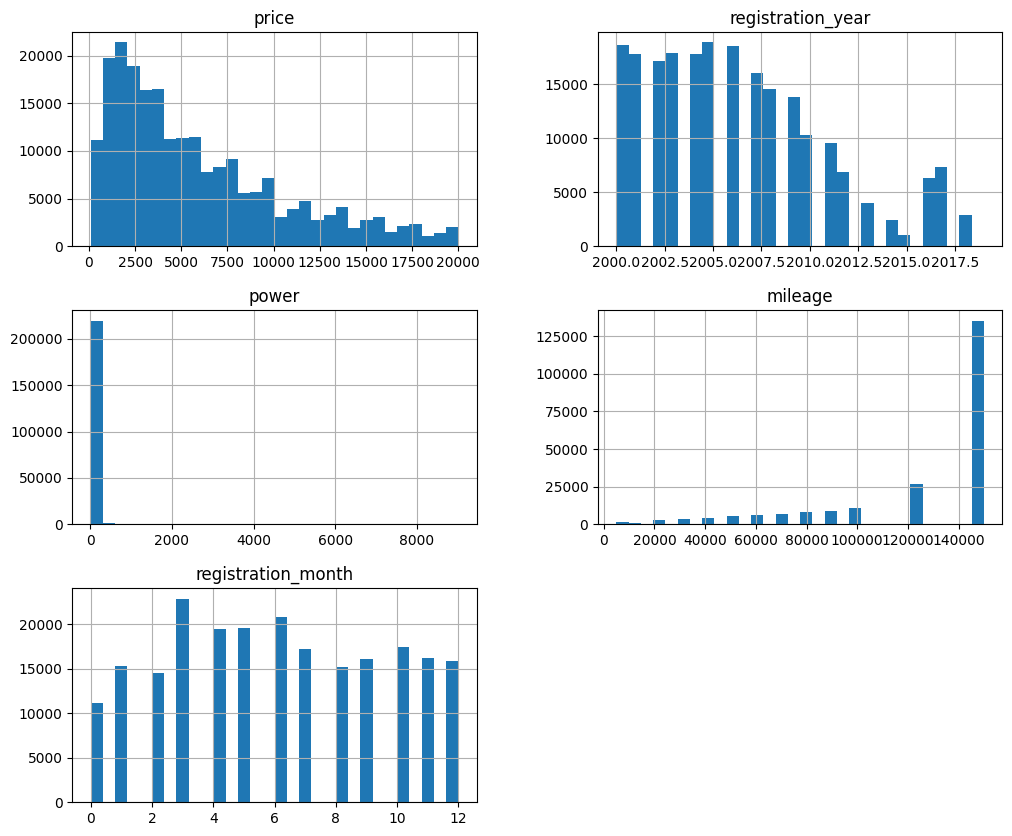

In [16]:
# Histogram to show the distribution of numerical features
df.hist(figsize=(12,10),bins=30)
plt.show()

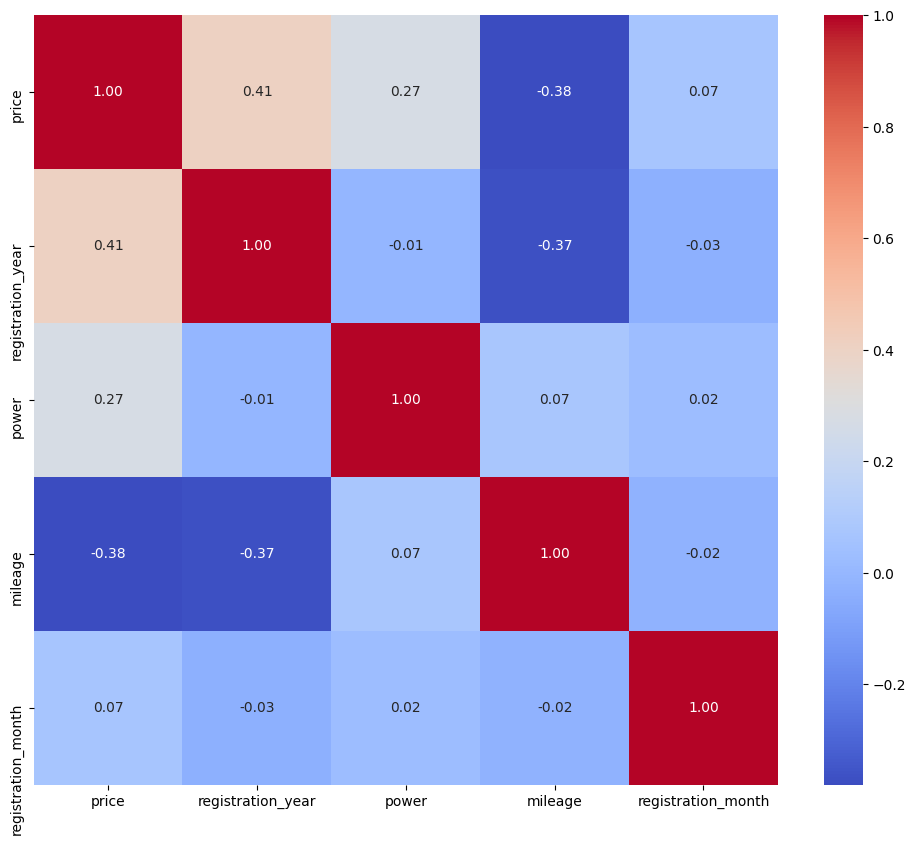

In [17]:
#Corelation heatmap displays corelation between quantitative features:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

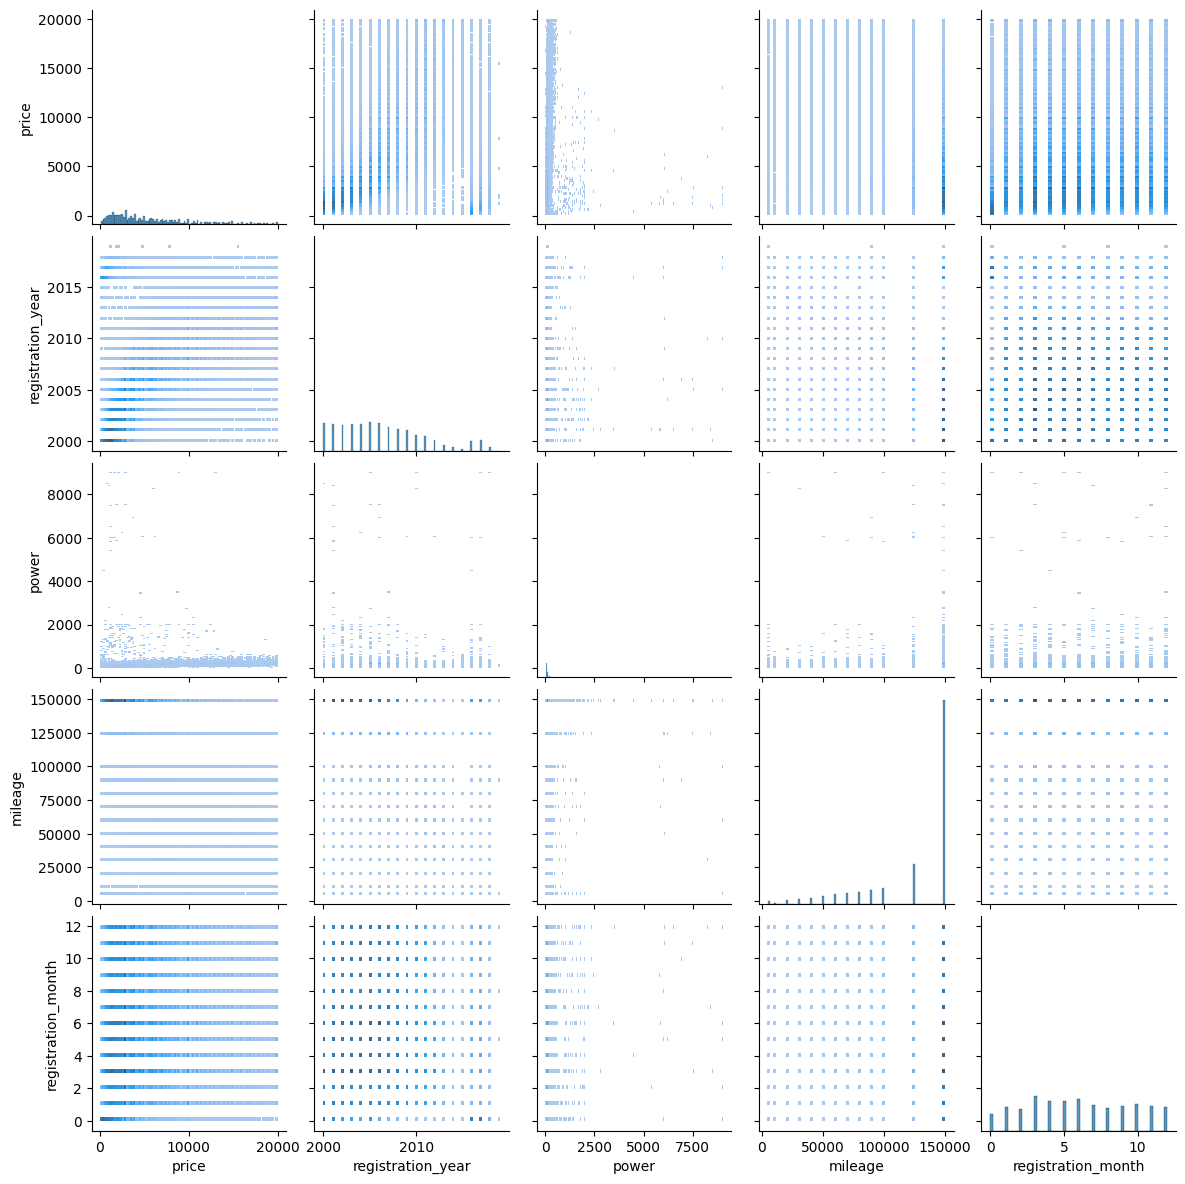

In [18]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

The above plot shows the relation between different numerical features.

## Model training

In [19]:
#Find the car age 
df['car_age'] =2025 -df['registration_year']

In [20]:
#Features and target
features=df.drop(columns=['price', 'registration_year','registration_month'])
target =df['price']

In [21]:
#Numerical and categorical features
numerical =['power', 'mileage','car_age']
categorical = ['vehicle_type', 'gearbox', 'model','fuel_type', 'brand', 'not_repaired']

In [22]:
#Split the data 
X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.25, random_state=42)

Column Transformer is handy for the case of datasets that contain heterogeneous data types, since we may want to scale the numeric features and one-hot encode the categorical ones.
In this example, the numeric data is standard-scaled after mean-imputation. The categorical data is one-hot encoded via OneHotEncoder, which creates a new category for missing values.

In [23]:
# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
])


In [32]:
#Linear regression(Sanity check)
# Define pipeline
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Train 
start_time = time.time()
lr_pipeline.fit(X_train, y_train)
lr_train_time = time.time() - start_time
# Evaluate
start_time = time.time()
preds = lr_pipeline.predict(X_valid)
lr_predict_time = time.time() - start_time

rmse = mean_squared_error(y_valid, preds, squared=False)
print(f"Linear Regression RMSE: {rmse:.2f}")
print(f"Training time: {lr_train_time:.4f}s")
print(f"Prediction time: {lr_predict_time:.4f}s")

Linear Regression RMSE: 2535.45
Training time: 7.0466s
Prediction time: 0.2082s


The Root Mean Squared Error (RMSE) is one of the two main performance indicators for a regression model. It measures the average difference between values predicted by a model and the actual values. It provides an estimation of how well the model is able to predict the target value (accuracy). The lower the value of the Root Mean Squared Error, the better the model is. The RMSE of the above model is 2533.64. The time required for training is 7.0466s and time for prediction is 0.2082s.

In [33]:
#Decision Tree Regressor
# Define pipeline
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

# Set up grid for basic tuning
dt_params = {
    'model__max_depth': [5, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

# Grid Search with 3-fold CV
grid_dt = GridSearchCV(dt_pipeline, dt_params, cv=3,
                       scoring='neg_root_mean_squared_error',
                       n_jobs=-1, verbose=2)
grid_dt.fit(X_train, y_train)
#Get the best model
best_model = grid_dt.best_estimator_
#Train the best model
start_time = time.time()
best_model.fit(X_train, y_train)
dt_train_time = time.time() - start_time
# Evaluate
start_time = time.time()
dt_preds = best_model.predict(X_valid)
dt_predict_time =  time.time() - start_time
dt_rmse = mean_squared_error(y_valid, dt_preds, squared=False)
print(f"Decision Tree RMSE: {dt_rmse:.2f}")
print(f"Training time: {dt_train_time:.4f}s")
print(f"Prediction time: {dt_predict_time:.4f}s")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .....model__max_depth=5, model__min_samples_split=2; total time=   0.4s
[CV] END .....model__max_depth=5, model__min_samples_split=2; total time=   0.4s
[CV] END .....model__max_depth=5, model__min_samples_split=2; total time=   0.4s
[CV] END .....model__max_depth=5, model__min_samples_split=5; total time=   0.4s
[CV] END .....model__max_depth=5, model__min_samples_split=5; total time=   0.4s
[CV] END .....model__max_depth=5, model__min_samples_split=5; total time=   0.4s
[CV] END ....model__max_depth=5, model__min_samples_split=10; total time=   0.4s
[CV] END ....model__max_depth=5, model__min_samples_split=10; total time=   0.4s
[CV] END ....model__max_depth=5, model__min_samples_split=10; total time=   0.4s
[CV] END ....model__max_depth=10, model__min_samples_split=2; total time=   1.4s
[CV] END ....model__max_depth=10, model__min_samples_split=2; total time=   1.4s
[CV] END ....model__max_depth=10, model__min_samp

The RMSE of the Decision Tree regressor model is 1847.72. The time required for training is 7.2325s and time for prediction is  0.0633s.

In [31]:
# For Random Forest Regressor
# Define pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Set up grid for basic tuning
rf_params = {
    'model__n_estimators': [50],
    'model__max_depth': [10, 20]
}

# Grid Search with 3-fold CV
grid_rf = GridSearchCV(rf_pipeline, rf_params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2)
grid_rf.fit(X_train, y_train)
#Get the best model
best_model = grid_rf.best_estimator_
#Train the best model
start_time = time.time()
best_model.fit(X_train, y_train)
training_time = time.time() - start_time
# Best model evaluation
start_time = time.time()
rf_preds = best_model.predict(X_valid)
predict_time_rf =  time.time() - start_time
rf_rmse = mean_squared_error(y_valid, rf_preds, squared=False)
print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"Training time: {training_time:.4f}s")
print(f"Prediction time: {predict_time_rf:.4f}s")

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ........model__max_depth=10, model__n_estimators=50; total time=  58.0s
[CV] END ........model__max_depth=10, model__n_estimators=50; total time=  58.0s
[CV] END ........model__max_depth=10, model__n_estimators=50; total time=  57.7s
[CV] END ........model__max_depth=20, model__n_estimators=50; total time= 4.3min
[CV] END ........model__max_depth=20, model__n_estimators=50; total time= 4.3min
[CV] END ........model__max_depth=20, model__n_estimators=50; total time= 4.3min
Random Forest RMSE: 1648.28
Training time: 427.0709s
Prediction time: 0.5051s


The RMSE of the Random Forest Regressor model is 1648.28. The time required for training is 427.0709s and time for prediction is 0.5051s.

In [34]:
#LightGBM model
# Prepare categorical indices for LightGBM
cat_features_lgb = [features.columns.get_loc(col) for col in categorical]

# Prepare LightGBM Dataset
X_train_lgb = X_train.copy()
X_valid_lgb = X_valid.copy()

# Convert string categories to "category" dtype for LightGBM
for col in categorical:
    X_train_lgb[col] = X_train_lgb[col].astype('category')
    X_valid_lgb[col] = X_valid_lgb[col].astype('category')

# Train LightGBM model
lgb_model = lgb.LGBMRegressor(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=10,
    random_state=42
)

start_time = time.time()
lgb_model.fit(X_train_lgb, y_train, categorical_feature=categorical)
lgb_train_time = time.time() - start_time
# Predict and evaluate
start_time = time.time()
lgb_preds = lgb_model.predict(X_valid_lgb)
lgb_predict_time = time.time() - start_time
lgb_rmse = mean_squared_error(y_valid, lgb_preds, squared=False)
print(f"LightGBM RMSE: {lgb_rmse:.2f}")
print(f"Training time: {lgb_train_time:.4f}s")
print(f"Prediction time: {lgb_predict_time:.4f}s")

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LightGBM RMSE: 1660.89
Training time: 2.1265s
Prediction time: 0.3227s


The RMSE of the LightGBM model is 1648.60. The time required for training is 2.1265s and time for prediction is 0.3227s.

In [36]:
#Cat Boost regressor
# Convert categorical columns to string (if needed)
X_train_cb = X_train.copy()
X_valid_cb = X_valid.copy()

for col in categorical:
    X_train_cb[col] = X_train_cb[col].astype(str)
    X_valid_cb[col] = X_valid_cb[col].astype(str)

# Initialize and train CatBoost
cb_model = CatBoostRegressor(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    loss_function='RMSE',
    cat_features=categorical,
    verbose=0,
    random_seed=42
)

# Train
start_time = time.time()
cb_model.fit(X_train_cb, y_train)
cb_train_time = time.time() - start_time
# Predict and evaluate
start_time = time.time()
cb_preds = cb_model.predict(X_valid_cb)
cb_predict_time=time.time() - start_time
cb_rmse = mean_squared_error(y_valid, cb_preds, squared=False)
print(f"CatBoost RMSE: {cb_rmse:.2f}")
print(f"Training time: {cb_train_time:.4f}s")
print(f"Prediction time: {cb_predict_time:.4f}s")

CatBoost RMSE: 1807.16
Training time: 5.6607s
Prediction time: 0.0384s


The RMSE of the CatBoost regressor model is 1807.16. The time required for training is 5.6607s and time for prediction is 0.0384s

In [37]:
#XGB regressor
# Build a pipeline for XGBoost
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        objective='reg:squarederror',
        n_jobs=-1,
        random_state=42
    ))
])

# Train
start_time = time.time()
xgb_pipeline.fit(X_train, y_train)
xgb_train_time = time.time() - start_time
# Predict and evaluate
start_time = time.time()
xgb_preds = xgb_pipeline.predict(X_valid)
xgb_predict_time=time.time() - start_time
xgb_rmse = mean_squared_error(y_valid, xgb_preds, squared=False)
print(f"XGBoost RMSE: {xgb_rmse:.2f}")
print(f"Training time: {xgb_train_time:.4f}s")
print(f"Prediction time: {xgb_predict_time:.4f}s")

XGBoost RMSE: 1754.25
Training time: 15.7943s
Prediction time: 0.3633s


The RMSE of the XGB regressor model is 1754.25 The time required for training is 15.7943s and time for prediction is 0.3633.

## Model analysis

In [38]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'LightGBM', 'CatBoost', 'XGBoost'],
    'RMSE': [rmse, dt_rmse, rf_rmse, lgb_rmse, cb_rmse, xgb_rmse],
    'Training Time':[lr_train_time, dt_train_time, training_time, lgb_train_time, cb_train_time, xgb_train_time],
    'Prediction Time':[lr_predict_time, dt_predict_time, predict_time_rf, lgb_predict_time, cb_predict_time, xgb_predict_time]
} )
print(results.sort_values(by='RMSE'))

               Model         RMSE  Training Time  Prediction Time
2      Random Forest  1648.280230     427.070927         0.505127
3           LightGBM  1660.890951       2.126513         0.322693
5            XGBoost  1754.249303      15.794274         0.363253
4           CatBoost  1807.156853       5.660737         0.038441
1      Decision Tree  1847.721846       7.256966         0.063311
0  Linear Regression  2535.453683       7.046596         0.208215


From the above different model RMSE Random Forest is better model for car prediction. But its training time is too long. LightGBM predicts faster than RandomForest Regressor.

## Conclusion:

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, we can quickly find out the market value of your car. We have access to historical data: technical specifications, trim versions, and prices.We need to build the model to determine the value. 
Rusty Bargain is interested in:
* the quality of the prediction
* the speed of the prediction
* the time required for training
This project is divided into 3 parts. The three steps are
- Data preparation
- Model training
- Model analysis

In the first stage, import the libraries and load the data. Check the data types, missing values and duplicates. Remove the outliers from the data. Conduct some exploratory analysis in the data.


Second stage consists of model traiing. Compare different models and find the RMSE, time for training and speed of prediction. The obtained outputs for different models are 

- Linear Regression RMSE: 2535.453683
- Random Forest RMSE: 1648.280230
- Decision Tree RMSE: 1847.721846
- LightGBM RMSE: 1660.890951
- CatBoost RMSE: 1807.156853
- XGBoost RMSE: 1754.249303
   
The time for training and prediction are:
- Linear Regression : The time required for training is 7.046596   and time for prediction is 0.505127s
- Decision Tree : The time required for training is  7.256966  and time for prediction is 63.3ms.
- Random Forest : The time required for training is 21min 27s and time for prediction is 0.505127s.
- LightGBM : The time required for training is 2.1265s and time for prediction is 0.3227s.
- CatBoost : The time required for training is  5.660737  and time for prediction is 0.038441
- XGBoost : The time required for training is 15.7943s and time for prediction is 0.3633.

In the third stage choose the better model. From the above models, RandomForest can be used for model prediction. But its training time is too long. LightGBM can be used to predict in a faster rate.

# Checklist

Type 'x' to check. Then press Shift+Enter.